In [1]:
import calendar
import cmocean as cmo
import gc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Define timestamp version of data to plot
TIMESTAMP_OUT = '01232026_1338'

# Define remaning parameters
HEM = 'sh'
MODEL_DIR = 'ps'
MODEL_STR = 'ps'

In [3]:
# Load uncertainty (from lr input)
fnam = f'/home/jbassham/jack/thesis-rough/data/lr-input/sh/{TIMESTAMP_OUT}/test_sh19922020_{TIMESTAMP_OUT}.npz'

data = np.load(fnam)
r_test = data['r_test']

In [4]:
# # Load test outputs
fnam = f"/home/jbassham/jack/thesis-rough/data/model-output/{MODEL_DIR}/{HEM}/{TIMESTAMP_OUT}/preds_{MODEL_STR}_{HEM}19922020_{TIMESTAMP_OUT}.npz"

data = np.load(fnam)

y_pred = data['y_pred']
y_true = data['y_true']

print(np.shape(y_pred))
print(np.shape(y_true))
print(np.shape(r_test))


(730, 2, 81, 522)
(730, 2, 81, 522)
(731, 81, 522)


In [ ]:
# Get current script directory
script_dir = "/home/jbassham/jack/thesis-rough/notebooks"

# Get root directory (one level above)
root = os.path.abspath(
    os.path.join(
        script_dir,
        '..',
    )
)

# Define function of month plots destination path
PATH_DEST = os.path.abspath(
    os.path.join(
        root,
        'plots',
        'eval_fcn_month',
        MODEL_DIR,
        HEM,
        TIMESTAMP_OUT,
    )
)

# Create the destination directory if it doesn't already exist
os.makedirs(PATH_DEST, exist_ok = True)

In [6]:
def correlation(pred, true):

    """
    Pearson Correlation
    """

    predbar = np.nanmean(pred, axis = 0) # mean predicted
    truebar = np.nanmean(true, axis = 0) # mean true

    covariance = np.nansum((pred - predbar) * (true - truebar), axis = 0) # covariance between predicted and true
    
    stdpred = np.sqrt(np.nansum((pred - predbar)**2, axis = 0)) # standard deviation predited
    stdtrue = np.sqrt(np.nansum((true - truebar)**2, axis = 0)) # standard deviation true

    correlation = covariance / (stdpred * stdtrue)

    return correlation

In [7]:
def weighted_correlation(pred, true, r, epsilon = 1e-4):

    """
    Weighted Pearson Correlation referenced from:
    https://www.air.org/sites/default/files/2021-06/Weighted-and-Unweighted-Correlation-Methods-Large-Scale-Educational-Assessment-April-2018.pdf
    
    """

    w = 1 / (r + epsilon)

    def weighted_mean(x, w):
        return np.nansum(w * x, axis = 0) / np.nansum(w, axis = 0)

    predbar = weighted_mean(pred, w) # weighted mean predicted
    truebar = weighted_mean(true, w) # weighted mean true

    weighted_cov = np.nansum(w * (pred - predbar) * (true - truebar), axis = 0) # weighted covariance between predicted and true
    
    weighted_stdpred = np.sqrt(np.nansum(w * (pred - predbar)**2, axis = 0)) # weighted standard deviation predited
    weighted_stdtrue = np.sqrt(np.nansum(w * (true - truebar)**2, axis = 0)) # weighted standard deviation true

    correlation = weighted_cov / (weighted_stdpred * weighted_stdtrue)

    return correlation

In [8]:
def skill(pred, true, epsilon = 1e-4):
    # NOTE excluding epsilon = 1e-4 from denominator for now

    mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term
    # MSE = E[(y-x)^2]
    # = (E[y-x])^2 + Var(y-x)
    # = bias^2 + Var(y-x)
    # Can prove the above

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    skill = 1 - mse / (vartrue + epsilon)

    return skill

In [9]:
def weighted_skill(pred, true, r, epsilon = 1e-4):
    # NOTE including epsilon = 1e-4 in the weights in case of uncertainty r ~ 0

    w = 1 / (r + epsilon)

    mse = np.nanmean(( w * (true - pred))**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean(( w * (true - truebar))**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    weighted_skill = 1 - mse / (vartrue + epsilon)

    return weighted_skill

In [10]:
def plot_metric(u_data, v_data, lon, lat, metric):

    # Set longitude bounds for plot (full zonal coverage)
    lon_min = -180
    lon_max = 180

    # Set latitude bounds based on hemisphere
    if HEM == 'sh':
        lat_min = -90
        lat_max = -65
    elif HEM =='nh':
        lat_min = 65
        lat_max = 90

    # Define plot proection based on hempisphere
    if HEM == 'sh':
        projection = ccrs.SouthPolarStereo()
    elif HEM == 'nh':
        projection = ccrs.NorthPolarStereo()

    # Define data-to-plot's coordinate reference system
    # NOTE, used for 'crs' and 'transform' cartopy parameters
    crs = ccrs.PlateCarree()

    # Set color map
    cmap = cmo.cm.balance_r  # red blue colormap from cmocean

    # Saturate colormap to -1 and 1 limits
    vmin = -1
    vmax = 1
    
    # Initialize subplots
    fig, axs = plt.subplots(
        nrows = 1,
        ncols = 2,
        figsize = (6,3),
        subplot_kw = {'projection': projection},
        constrained_layout = True
    )

    # Plot left plot; zonal evaluation
    axs[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs = crs)
    axs[0].coastlines
    # Plot pcolormesh plot
    pcm_0 = axs[0].pcolormesh(
        lon, lat, u_data,
        transform = crs,
        cmap = cmap, vmin = vmin, vmax = vmax
    )
    axs[0].set_title("zonal")
    # Add colorbar
    plt.colorbar(pcm_0, ax = axs[0], orientation = 'vertical')

    # Plot right plot; meridional evaluation
    axs[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs = crs)
    axs[1].coastlines
    # Plot pcolormesh plot
    pcm_1 = axs[1].pcolormesh(
        lon, lat, v_data,
        transform = crs,
        cmap = cmap, vmin = vmin, vmax = vmax
    )
    axs[1].set_title("meridional")
    # Add colorbar
    plt.colorbar(pcm_1, ax = axs[1], orientation = 'vertical')

    # Add title to plot
    fig.suptitle(f"{metric}; {MODEL_STR.upper()}", fontweight = 'bold')

    # Format with tight layout
    fig.tight_layout

    # Add text with means
    fig.text(0, -0.05, f"mean zonal {metric}: {np.nanmean(u_data):.4f}")
    fig.text(0.5, -0.05, f"mean meridional {metric}: {np.nanmean(v_data):.4f}")

    # Define filemane for figure
    fnam = f"{metric}_{MODEL_STR}_{TIMESTAMP_OUT}.png"

    # Save figure
    plt.savefig(os.path.join(PATH_DEST, fnam), bbox_inches = 'tight')

    return

In [11]:
def plot_fcn_month(y_pred, y_true, time, lon, lat, metric_fcn, metric_str, r = None):

    """

    Computes and plots the given metric function for each month of the year
    Given inputs:
        y_pred: shaped [nt,2,nlat,nlon]; where y_pred[:,0,:,:] is the u component and y_pred[:,1,:,:] is the v component
        y_true: shaped [nt,2,nlat,nlon]; where y_true[:,0,:,:] is the u component and y_pred[:,1,:,:] is the v component
        lon: longitude
        lat: latitude
        metric_fcn: skill, weighted_skill, correlation, or weighted_correlation functions
        *metric_args and **metric_kwargs: attitional arguments for metric functions (ie: r for weighted)

    """

    # Get shape for spatial dimensions
    nt, _, nlat, nlon = np.shape(y_pred)

    # Define number of month bins
    nm = 12 # number months

    # Initialize empty arrays containing metrics for each month of the year
    u_metric_allyear = np.full((nm, nlat, nlon), np.nan)
    v_metric_allyear = np.full((nm, nlat, nlon), np.nan)

    # Get month numbers from time variable
    months = (time.astype('datetime64[M]').astype(int) % 12) + 1

    # # Create array of month strings for plot titles
    # month_strings = [calendar.month_name[m] for m in range(1,13)]

    for i in range(0,12):

        month = months == (i + 1)

        if r is None:
            u_metric_month = metric_fcn(
                y_pred[month,0,:,:],
                y_true[month,0,:,:],
            )
            v_metric_month = metric_fcn(
                y_pred[month,1,:,:],
                y_true[month,1,:,:],
            )

        else:
            u_metric_month = metric_fcn(
                y_pred[month,0,:,:],
                y_true[month,0,:,:],
                r = r[month],
            )
            v_metric_month = metric_fcn(
                y_pred[month,1,:,:],
                y_true[month,1,:,:],
                r = r[month],
            )

        # # Compute u and v metrics, including arbitrary arguments for case of r input for weighted
        # u_metric_month = metric_fcn(y_pred[months==i+1,0,:,:], y_true[months==i+1,0,:,:], *metric_args[months==i+1,0,:,:], **metric_kwargs)
        # v_metric_month = metric_fcn(y_pred[months==i+1,1,:,:], y_true[months==i+1,1,:,:], *metric_args[months==i+1,0,:,:], **metric_kwargs)

        # Fill current month in year long array
        u_metric_allyear[i, :, :] = u_metric_month
        v_metric_allyear[i, :, :] = v_metric_month

        # Get the month string for current month 
        month_str = calendar.month_name[i+1]

        # Plot the u and v metric for that month
        plot_metric(u_metric_month, v_metric_month, lon, lat, metric_str + " " + month_str)

    # Return arrays with metric for each month
    return u_metric_allyear, v_metric_allyear    

In [ ]:
def plot_avg_metric(u_metric, v_metric, metric_str):
    """
    Plots the spatial average of metric for each month in time series
    """

    # Create array of month strings for plot titles
    month_strings = [calendar.month_name[m] for m in range(1,13)]

    if HEM == 'sh':
        hem_str = 'Southern Ocean'
    
    elif HEM == 'nh':
        hem_str = 'Arctic'

    # Average into monthly bins
    u_metric_bar = np.nanmean(u_metric, axis = (1,2))
    v_metric_bar = np.nanmean(v_metric, axis = (1,2))

    plt.plot(u_metric_bar, marker='o', label='zonal')
    plt.plot(v_matric_bar, marker='o', label='meridional')
    plt.xticks(np.arange(12), month_strings, rotation=45)
    plt.ylabel('metric')
    plt.title(f"{hem_str} {metric_str}; {MODEL_STR.upper()}", fontsize = 14, fontweight = 'bold')
    plt.legend()

    # Define filemane for figure
    fnam = f"{metric_str}year_{MODEL_STR}_{TIMESTAMP_OUT}.png"

    # Save figure
    plt.savefig(os.path.join(PATH_DEST, fnam), bbox_inches = 'tight')


    plt.show()


In [13]:
# Load test split indices (from lr input) 
fnam = '/home/jbassham/jack/thesis-rough/data/lr-input/sh/01232026_1338/split_indices_lr_sh19922020_01232026_1338.npz'

data = np.load(fnam)
test_idx = data['test_idx']

In [14]:
# Load coordinates
fnam = '/home/jbassham/jack/thesis-rough/data/coordinates/sh/01072026_1643/coord_sh19922020_01072026_1643.npz'

data = np.load(fnam)
lat = data['lat']
lon = data['lon']

# Load time in while slicing to test indices
time = data['time'][test_idx]

/tmp/ipykernel_1118662/2115513631.py:4: RuntimeWarning: Mean of empty slice
  mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
/tmp/ipykernel_1118662/2115513631.py:11: RuntimeWarning: Mean of empty slice
  truebar = np.nanmean(true, axis = 0) # mean true
/tmp/ipykernel_1118662/2115513631.py:13: RuntimeWarning: Mean of empty slice
  vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true


FileNotFoundError: [Errno 2] No such file or directory: '/home/jbassham/jack/thesis-rough/plots/eval_fcn_month/ps/sh/01232026_1338/skill January_ps_01232026_1338.png'

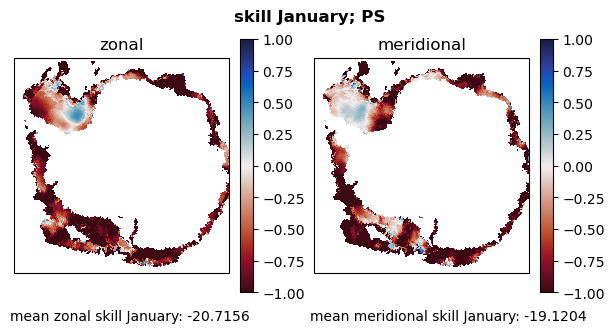

In [15]:
# TODO fix dimension persistence

# NOTE removing last day from time and r for persistence (persistence 1 day short)

if MODEL_STR == 'ps':
    # Compute skill as a function of month
    u_skill_month , v_skill_month = plot_fcn_month(y_pred, y_true, time[:-1], lon, lat, skill, 'skill')

    # Compute weighted skill as a function of month
    u_wtdskill_month , v_wtdskill_month = plot_fcn_month(y_pred, y_true, time[:-1], lon, lat, weighted_skill, 'wtd skill', r = r_test[:-1,:,:])

    # Compute correlation as a function of month
    u_corr_month_ps , v_corr_month = plot_fcn_month(y_pred, y_true, time[:-1], lon, lat, correlation, 'corr')

    # Compute weighted correlation as a function of month
    u_wtdcorr_month , v_wtdcorr_month = plot_fcn_month(y_pred, y_true, time[:-1], lon, lat, weighted_correlation, 'wtd corr', r = r_test[:-1,:,:])

else: 
    # Compute skill as a function of month
    u_skill_month , v_skill_month = plot_fcn_month(y_pred, y_true, time, lon, lat, skill, 'skill')

    # Compute weighted skill as a function of month
    u_wtdskill_month , v_wtdskill_month = plot_fcn_month(y_pred, y_true, time, lon, lat, weighted_skill, 'wtd skill', r = r_test[:-1,:,:])

    # Compute correlation as a function of month
    u_corr_month_ps , v_corr_month = plot_fcn_month(y_pred, y_true, time, lon, lat, correlation, 'corr')

    # Compute weighted correlation as a function of month
    u_wtdcorr_month , v_wtdcorr_month = plot_fcn_month(y_pred, y_true, time, lon, lat, weighted_correlation, 'wtd corr', r = r_test[:-1,:,:])



In [16]:
# Compute mean skill each month
plot_fcn_month(u_skill_month , v_skill_month, 'skill')

# Compute mean weighted skill each month
plot_fcn_month(u_wtdskill_month , v_wtdskill_month, 'wtd skill')

# Compute mean weighted skill each month
plot_fcn_month(u_corr_month , v_corr_month, 'corr')

# Compute mean weighted skill each month
plot_fcn_month(u_wtdcorr_month , v_wtdcorr_month, 'wtd corr')



NameError: name 'u_skill_month' is not defined